In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity, adjust_gamma
from tqdm import tqdm
from scipy.ndimage import binary_erosion, binary_dilation
from math import hypot
import warnings
import pickle
from diffsims.libraries.diffraction_library import load_DiffractionLibrary, _get_library_entry_from_angles
from pyxem.utils import indexation_utils as iutls
warnings.filterwarnings(action='ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# %matplotlib notebook


def CustomCmap(from_rgb,to_rgb):            ###################### generate colormap

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


cmaps= [                       ###################### generate colormap
    CustomCmap([0,0,0],[1,0,0]),
    CustomCmap([0,0,0],[0,1,0]),
    CustomCmap([0,0,0],[0,0,1]),
    CustomCmap([0,0,0],[1,1,0]),
    CustomCmap([0,0,0],[0,1,1]),
    CustomCmap([0,0,0],[1,0,1]),
    CustomCmap([0,0,0],[.5,0.2,1]),
    CustomCmap([0,0,0],[.2,0.5,1]),
    CustomCmap([0,0,0],[1,.2,.5]),
    CustomCmap([0,0,0],[.2,1,.5])
]
cmaps *= 200

def subtract_background_dog(z, sigma_min, sigma_max):        ###################### background subtract for diffraction image
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image, threshold = 1, gamma = 0.2):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < threshold] = 0
    # change the gamma of the images
    image = adjust_gamma(image, gamma)
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

num_mapping = 3
def plot_non_mix_mapping(loading_matrix, save = False, save_path= f"image/{num_mapping}/merged_mapping.png", annotation=False):
    shape = loading_matrix.shape
    mapping_index = np.zeros([shape[1],shape[2]])
    for i in range(shape[1]):
        for j in range(shape[2]):
            if loading_matrix[:,i,j].max() > 1:
                mapping_index[i, j] = loading_matrix[:,i,j].argmax()
    plt.figure()
    plt.imshow(mapping_index,cmap = 'jet')
    if annotation == True:
        for i in range(loading_matrix.shape[0]):
            plt.annotate(i, ndimage.measurements.center_of_mass(loading_matrix[i])[::-1])
    if save: 
        plt.imsave(save_path, mapping_index, cmap = 'jet')
        
def plot_mix_mapping(loading_matrix, num_plot = 0, gamma = 1, interp_scale = (2,2), plot = False, save = False, save_path= f"image/{num_mapping}/merged_mapping.png", annotation=False):
    shape = loading_matrix.shape
    mapping_index = np.zeros([shape[1],shape[2],4])
    if num_plot == 0: num_plot = shape[0]
    for i in tqdm(range(num_plot)):
        img = adjust_gamma(loading_matrix[i], gamma)
        colored = cmaps[i](img)
        colored[:,:,3] = rescale_intensity(img, out_range=(0,1))
        mapping_index += colored
    mapping_index[:,:,3] = rescale_intensity(mapping_index[:,:,3], out_range=(0,1))
    mapping_index[:,:,0] = rescale_intensity(mapping_index[:,:,0], out_range=(0,1))
    mapping_index[:,:,1] = rescale_intensity(mapping_index[:,:,1], out_range=(0,1))
    mapping_index[:,:,2] = rescale_intensity(mapping_index[:,:,2], out_range=(0,1))
    mapping_index = cv2.resize(mapping_index,None, fx = interp_scale[0], fy = interp_scale[1], interpolation = cv2.INTER_NEAREST)
    if annotation:
        for i in range(num_plot):
            center_of_mass = ndimage.measurements.center_of_mass(loading_matrix[i])[::-1]
            center_of_mass = (int(center_of_mass[0]*interp_scale[0]), int(center_of_mass[1]*interp_scale[1]))
            cv2.putText(mapping_index, str(i), center_of_mass, fontFace = cv2.FONT_ITALIC, fontScale = .4, color = (1.,0.,0.,1.))
    if plot:
        plt.figure()
        plt.imshow(mapping_index,cmap = 'jet')
        if save: 
            plt.imsave(save_path, mapping_index, cmap = 'jet')
    else:
        return mapping_index
    
class grain:
    def __init__(self, load_map, diff_pattern, contour = False, loc = False, area=False, central_diff_pattern = -1, index = -1):
        if load_map is not None:
            self.load_map = load_map
            self.origin_loc = ndimage.measurements.center_of_mass(load_map)
        if diff_pattern is not None:
            self.diff_pattern = diff_pattern
        if contour:
            self.init_contour = contour
        else:
            if load_map is not None:
                contours, hierarchy = cv2.findContours(np.uint8(binary_erosion(load_map,iterations=1)), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
                self.init_contour = contours
        if loc:
            self.loc = loc
        else:
            self.loc = self.origin_loc
        
        if area:
            self.area = area
        else:
            self.area = load_map.sum() # nm^2
        self.index = index # keep all 0.9*max_cross_corr, in sequence of cross_corr
        self.central_diff_pattern = central_diff_pattern
        
    def update_diff_pattern_center_region(self, original_dataset, dilation = 2):
        loc = np.array(self.origin_loc).astype(int)
        start_x, start_y = max(0, int(loc[0]-dilation)), max(0, int(loc[1]-dilation))
        end_x, end_y = min(400, int(loc[0]+dilation+1)), min(400, int(loc[1]+dilation+1))
        self.central_diff_pattern = original_dataset.inav[start_y:end_y,start_x:end_x].mean(axis = (0,1))
        self.central_diff_patterns = original_dataset.inav[start_y:end_y,start_x:end_x]
        
    def indexation(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        all_index = index_map[self.load_map][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def indexation_center_region(self, index_map, filter_misori_threshold = 10, take_num = 1, save_num = 5, dilation = 2): 
        # index using pre_indexed mapping - index_map, must be done before any drift correction (for consistency in grain location)
        loc = np.array(self.origin_loc).astype(int)
        all_index = index_map[loc[0]-dilation:loc[0]+dilation,loc[1]-dilation:loc[1]+dilation][:take_num].reshape(-1, 4)
        all_index_filtered = vote_orientation(all_index, 10)
#         all_index_filtered = vote_orientation_w_error(all_index, 10)
        all_index_filtered = all_index_filtered[all_index_filtered[:, 3].argsort()[::-1]]
        num_to_save = min(save_num, len(all_index_filtered))
        self.index = all_index_filtered[:num_to_save]
        self.index[:,3] = self.index[:,3]/self.index[:,3].sum()  # normalize
        
    def index_by_function(self, lib):    # index self.central_diff_pattern, need update_diff_pattern_center_region first
        
        result, phasedict = iutls.index_dataset_with_template_rotation(self.central_diff_pattern,
                                                    diff_lib_pt, n_best = 10, intensity_transform_function = process_image)
        self.index = np.concatenate([result['orientation'][0][0],np.transpose(result['correlation'][0])],axis=1)
        
    def aligned_mapping(self, perspective_matrix, output_image_size):
        # perspective matrix is relative to first frame
        # output_image_size is to make sure entire image is in view zone
        self.load_map = cv2.warpPerspective(np.float32(self.load_map), perspective_matrix, output_image_size)
        self.load_map = self.load_map > 0.5
        self.loc = ndimage.measurements.center_of_mass(self.load_map)
        self.area = self.load_map.sum() # nm^2
        
def save_data(data,loc):
    with open(loc, "wb") as f:
        pickle.dump(data, f)
        
def load_data(loc):
    with open(loc, "rb") as f:
        return pickle.load(f)
    
def get_grains_in_chain(grain_chain, grain_list_all):
    grain_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_list.append(grain_list_all[i][grain_num])
    return grain_list
    
def grain_track_gif(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 3, diff_center = 'True'):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        
    frames = []
    frames_num = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            grain_size.append(None); 
            in_plane_ori.append(None);
            continue;
        frames_num.append(i)
        grain_size.append(np.sqrt(grain_list_all[i][grain_num].area)/np.pi);
        orientation = grain_list_all[i][grain_num].index[0]
        orientations.append(orientation)

        if diff_center:
            img = adjust_gamma(grain_list_all[i][grain_num].central_diff_pattern.data, 0.4)
        else:
            img = adjust_gamma(grain_list_all[i][grain_num].diff_pattern, 0.4)
        
        grain_loc = grain_list_all[i][grain_num].origin_loc
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, grain_list_all[i][grain_num].init_contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        img = rescale_intensity(img,out_range=(0,1))
        data = np.asarray(img) * 255
        data = data.astype(np.uint8)
        frame = cv2.cvtColor(np.asarray(data), cv2.COLOR_GRAY2BGR)
        shape_x, shape_y = frame.shape[0], frame.shape[1]
        inset_x, inset_y = int(shape_x*0.4), int(shape_y*0.4)
        frame[:inset_x,:inset_y] = cv2.resize(img_x, (inset_x, inset_y))
        frames.append(frame)
    with imageio.get_writer("image/grain_chain_"+str(grain_chain_num)+".gif", mode="I", duration=1) as writer:
        for idx, frame in enumerate(frames):
            cv2.putText(frame, str(frames_num[idx]), (100,110), fontFace = cv2.FONT_ITALIC, fontScale = 1, color = (0,255,0,255))
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            writer.append_data(rgb_frame)
            
def length_larger_than(grain_list, thres):
    return_list = []
    for i in grain_list:
        if (np.array(i) != -1).astype(int).sum() >= thres:
            return_list.append(i)
    return return_list

In [2]:
# load grain information and grain chains
grain_list_all = load_data("data/grain_list.dat")
diff_lib_pt = load_DiffractionLibrary("data/Pt_lib_0.5deg_0.1me.pickle", True)
grain_chain_filtered = load_data("data/grain_chain.dat").astype(int)


In [10]:
# merge adjecent grain chains into long chains
grain_chain_1 = all_grain_pairs['98'][:,:2].astype(int)
grain_chain_2 = all_grain_pairs['87'][:,:2].astype(int)
grain_chain_new = []

grain_chain_1 = np.concatenate([  grain_chain_1, [[-1] for i in range(grain_chain_1.shape[0])]  ],axis = 1)
grain_chain_2 = np.concatenate([  [[-1] for i in range(grain_chain_2.shape[0])], grain_chain_2  ],axis = 1)
grain_chain_new = np.concatenate([grain_chain_1,grain_chain_2])
to_combine_list = []
conbined_chain = []
for i in range(grain_chain_new.shape[0]-1):
    for j in range(i+1, grain_chain_new.shape[0]):
        if grain_chain_new[i,1] == grain_chain_new[j,1]:
            to_combine_list.append([i,j])
            combined = np.concatenate([grain_chain_new[i,:2], [grain_chain_new[j,2]]])
            conbined_chain.append(combined)
to_combine_list = np.array(to_combine_list).flatten()            
mask = np.ones(grain_chain_new.shape[0]).astype(bool)
mask[to_combine_list] = False
grain_chain_new = grain_chain_new[mask]
grain_chain_new = np.concatenate([grain_chain_new, conbined_chain])
grain_chain_new = grain_chain_new[grain_chain_new[:,0].argsort()]

for num_mapping in np.arange(7, 3, -1):
    print(num_mapping)
    grain_chain_1 = grain_chain_new
    num_pairs = str(num_mapping)+str(num_mapping-1)
    grain_chain_2 = all_grain_pairs[num_pairs][:,:2].astype(int)
    grain_chain_new = []

    grain_chain_1 = np.concatenate([  grain_chain_1, [[-1] for i in range(grain_chain_1.shape[0])]  ],axis = 1)
    joint_point = 9-num_mapping
    grain_chain_2 = np.concatenate([  [[-1]*joint_point for i in range(grain_chain_2.shape[0])], grain_chain_2],axis = 1)
    grain_chain_new = np.concatenate([grain_chain_1,grain_chain_2])
    to_combine_list = []
    conbined_chain = []
    for i in range(grain_chain_new.shape[0]-1):
        if grain_chain_new[i,joint_point] == -1: continue;
        for j in range(i+1, grain_chain_new.shape[0]):
            if grain_chain_new[i,joint_point] == grain_chain_new[j,joint_point]:
                to_combine_list.append([i,j])
                combined = np.concatenate([grain_chain_new[i,:-1], [grain_chain_new[j,-1]]])
                conbined_chain.append(combined)
    to_combine_list = np.array(to_combine_list).flatten()            
    mask = np.ones(grain_chain_new.shape[0]).astype(bool)
    mask[to_combine_list] = False
    grain_chain_new = grain_chain_new[mask]
    grain_chain_new = np.concatenate([grain_chain_new, conbined_chain])
    grain_chain_new = grain_chain_new[grain_chain_new[:,0].argsort()]

7
6
5
4


<IPython.core.display.Javascript object>


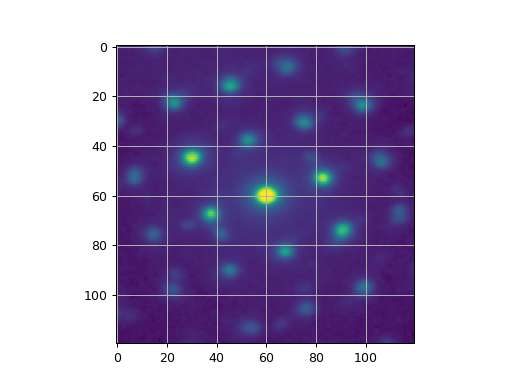

In [36]:
grain_chain_filtered = length_larger_than(grain_chain_new, 3)
grain_chain_random = grain_chain_filtered[534]
grain_list = get_grains_in_chain(grain_chain_random, grain_list_all)
img = grain_list[0].central_diff_pattern.data
for i in grain_list[1:]:
    img += i.central_diff_pattern
img = img/len(grain_list)
plt.figure()
plt.imshow(adjust_gamma(img, 0.4))

# index grain.central_diff_pattern by grain_chain

In [3]:
def process_image(image, threshold = 2, gamma = 0.4):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < 2] = 0
    # change the gamma of the images
    image = adjust_gamma(image, gamma)
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

from scipy.ndimage import interpolation
from diffsims.libraries.diffraction_library import load_DiffractionLibrary, _get_library_entry_from_angles

############################################### self written correlation function for matching

def correlation(image, simu):         # normalized by simulation intensity, anchored for same image
    return np.sum(np.multiply(image, simu)) / np.linalg.norm(simu)

def correlation_map(image, lib):
    simu_img_lib = lib['pt']['simulations']
    num = simu_img_lib.shape[0]
    rotation = np.arange(0,180,2)
    total_confid = np.zeros([num, len(rotation)])
    for i in tqdm(range(num)):
        simu_img = simu_img_lib[i].get_diffraction_pattern(size = 120, sigma = 2)
        for j, angle in enumerate(rotation):
            simu_img_rotated = interpolation.rotate(simu_img, angle, reshape=False)
            total_confid[i, j] = correlation(image, simu_img_rotated)
    return total_confid
            
    

def correlation_map_no_rotation(image, library, n_largest):
    top_matches = np.empty((len(library), n_largest, 3), dtype='object')

    for phase_index, library_entry in enumerate(library.values()):
        orientations = library_entry['orientations']
        pixel_coords = library_entry['pixel_coords']
        intensities = library_entry['intensities']
        
        or_saved, corr_saved = np.empty((n_largest, 3)), np.zeros((n_largest, 1))
        for (or_local, px_local, int_local) in zip(orientations, pixel_coords, intensities):
            image_intensities = image[px_local[:, 1], px_local[:, 0]]
            corr_local = np.sum(np.multiply(image_intensities, int_local)) / int_local.sum()
                  
            if corr_local > np.min(corr_saved):
                or_saved[np.argmin(corr_saved)] = or_local
                corr_saved[np.argmin(corr_saved)] = corr_local

            combined_array = np.hstack((or_saved, corr_saved))
            combined_array = combined_array[np.flip(combined_array[:, 3].argsort())]  
            top_matches[phase_index, :, 0] = phase_index
            top_matches[phase_index, :, 2] = combined_array[:, 3]  
            for i in np.arange(n_largest):
                top_matches[phase_index, i, 1] = combined_array[i, :3] 

    return top_matches.reshape(-1, 3)

def correlation_map_fast(image, library):
    rotation_match = np.zeros([3*90,4])
    for j,angle in enumerate(range(0,180,2)):
        image_rotate = interpolation.rotate(image, angle, reshape=False)
        matching = correlation_map_no_rotation(image_rotate, library, 3)
        for i in range(len(matching)):
            matching[i][1][0] = angle
            rotation_match[j*3+i,:3] = matching[i][1]
            rotation_match[j*3+i,3] = matching[i][-1]
    return rotation_match


def find_nth_peaks(confid_curve, threshold = 0.9, max_n = 3): 
    valleys_ind = argrelextrema(confid_curve, np.less)[0][0]
    confid_curve_shift = np.roll(confid_curve, valleys_ind)
    peaks, _ = find_peaks(confid_curve_shift)
    max_one = confid_curve_shift[peaks].argmax()
    peaks_above_threshold = confid_curve_shift[peaks] > confid_curve_shift[peaks][max_one]*threshold
    peaks_above_threshold = min(3, peaks_above_threshold.sum())
    peak_heights = confid_curve_shift[peaks]
    return peaks[np.argsort(peak_heights)[::-1][:peaks_above_threshold]]-valleys_ind
        
def correlation_map_fast_1d_dataset(imageset, library, plot_interval = 0, threshold = 2, gamma = 0.4, threshold_peak=0.8):
    match_result = []
    for image_num, image in enumerate(tqdm(imageset)):
        rotation_match = correlation_map_fast(process_image(image), library)
        rotation_match[:,-1] = gaussian_filter(rotation_match[:,-1], 3)
#         plt.figure()
#         plt.plot(rotation_match[:,-1])
        peaks = find_nth_peaks(rotation_match[:,-1], threshold = threshold_peak)
        match_result.append(rotation_match[peaks])
#         print(rotation_match[peaks])
        
        ################################ plot module
        if plot_interval != 0:
            if image_num % plot_interval == 0:
                plt.figure(figsize=(9,3))
                plt.subplot(1,4,1)
                plt.imshow(image)
                plt.subplot(1,4,2)
                num_of_label = 0
                Euler_angle = (0, rotation_match[peaks][num_of_label][1], rotation_match[peaks][num_of_label][2])
                library_entry = _get_library_entry_from_angles(library,'pt',Euler_angle)
                rotation = -1*rotation_match[peaks][num_of_label][0]
                simu_img_rotated = interpolation.rotate(library['pt']['simulations'][library_entry].get_diffraction_pattern(shape = (120, 120), sigma = 2), rotation, reshape=False)
                plt.imshow(process_image(image))
                plt.imshow(simu_img_rotated,alpha=rescale_intensity(simu_img_rotated,out_range=(0,1)),cmap='Reds')
                plt.subplot(1,4,3)
                plt.imshow(simu_img_rotated,cmap='Reds')
                plt.subplot(1,4,4)
                plt.plot(rotation_match[:,-1])
        ################################
    return match_result

In [4]:
## statistic change of grain size
from orix.quaternion import Misorientation, symmetry
from orix.quaternion import Orientation, symmetry
from orix.vector import Vector3d

def grain_size_from_chain(grain_chain, grain_list_all):
    grain_size = []
    for i,grain_num in enumerate(grain_chain):
        if grain_num == -1: continue;
        grain_size.append(np.sqrt(grain_list_all[6-i][grain_num].area)/np.pi);
    return np.array(grain_size)

def delta_grain_size_from_chain(grain_chain, grain_list_all):
    grain_size = grain_size_from_chain(grain_chain, grain_list_all)[::-1]
    delta_grain_size = grain_size[1:] - grain_size[:-1]
    return delta_grain_size

def ipf_misori_from_chain(grain_chain, grain_list_all,direction = (1, 0, 0)):
    grain_index = []
    for i,grain_num in enumerate(grain_chain):
        if grain_num == -1: continue;
        rad = np.radians(grain_list_all[6-i][grain_num].index[0][:3])
        ori = Orientation.from_euler(rad,symmetry = symmetry.Oh)
        vec = (ori[0] * Vector3d(direction)).in_fundamental_sector(symmetry.Oh)
        grain_index.append(vec);
    grain_index = np.array(grain_index)[::-1]
#     print(grain_index[-1].data[0], grain_index[0].data[0])
    misori = []
    for i in range(len(grain_index)-1):
        misori.append(euclidean(grain_index[i].data[0], grain_index[i+1].data[0]))
    return np.array(misori)

def reduced_misori_from_chain(grain_chain, grain_list_all):
    grain_index = []
    for i,grain_num in enumerate(grain_chain):
        if grain_num == -1: continue;
        rad = np.radians(grain_list_all[6-i][grain_num].index[0][:3])
        ori = Orientation.from_euler(rad,symmetry = symmetry.Oh)
        ori.symmetry = symmetry.Oh
        ori = ori.map_into_symmetry_reduced_zone()
        grain_index.append(ori.data[0])
    grain_index = np.array(grain_index)
    ori = Orientation(grain_index,symmetry = symmetry.Oh)
    ori = ori.get_distance_matrix()[0]
    misori = []
    for i in range(len(grain_index)-1):
        misori.append(ori[i][i+1])
    return misori
    
def grain_ori_from_chain(grain_chain, grain_list_all):
    grain_index = []
    for i,grain_num in enumerate(grain_chain):
        if grain_num == -1: continue;
        grain_index.append(grain_list_all[6-i][grain_num].index[0][:3]);
    return np.array(grain_index)

def grain_chain_ori_all_in_range(grain_chains, grain_list_all, ranges):
    mask = []
    for grain_chain in grain_chains:
        misori = ipf_misori_from_chain(grain_chain, grain_list_all)
        m=0
        for i in misori:
            if ranges[0]>i or i>ranges[1]:
                m = 1
        if m ==0:
            mask.append(True)
        else:
            mask.append(False)
    grain_chains = np.array(grain_chains)
    grain_chains_filtered = grain_chains[mask]
    return grain_chains_filtered

def grain_chain_ori_one_in_range(grain_chains, grain_list_all, ranges):
    mask = []
    for grain_chain in grain_chains:
        misori = ipf_misori_from_chain(grain_chain, grain_list_all)
        m=0
        for i in misori:
            if ranges[0]<i and i<ranges[1]:
                m = 1
        if m ==0:
            mask.append(False)
        else:
            mask.append(True)
    grain_chains = np.array(grain_chains)
    grain_chains_filtered = grain_chains[mask]
    print(mask.sim())
    return grain_chains_filtered
############################################################################ plot
grain_chain_filtered = length_larger_than(grain_chain_new, 3)
delta_grain_size_list = []
misori_list = []
for i in grain_chain_filtered:
    grain_size_list = grain_size_from_chain(i, grain_list_all)
    delta_grain_size = delta_grain_size_from_chain(i, grain_list_all)
    
    misori = ipf_misori_from_chain(i, grain_list_all)
    for i,j in zip(delta_grain_size, misori):
        delta_grain_size_list.append(i)
        misori_list.append(j)

    
print(len(delta_grain_size),'grains are counted')
plt.figure()
plt.hist(delta_grain_size_list,bins = 30,rwidth = 0.8)
plt.xlabel(r'Change of grain size/ nm')
plt.ylabel(r'Number of grains')

misori = np.unique(misori)
plt.figure()
plt.hist(misori_list,bins = 30,rwidth = 0.8)
plt.xlabel(r'Change of orientation/ rad')
plt.ylabel(r'Number of grains')



NameError: name 'grain_chain_new' is not defined

In [ ]:
from pyxem.utils.polar_transform_utils import (
    _cartesian_positions_to_polar,
    get_polar_pattern_shape,
    image_to_polar,
    get_template_polar_coordinates,
    _warp_polar_custom,
    
)
from pyxem.utils.indexation_utils import (
    _simulations_to_arrays,
    _get_integrated_polar_templates,
    _norm_rows,
    _get_max_n,
    _prefilter_templates
)
from numba import njit, prange
from scipy.ndimage import interpolation

def _match_polar_to_polar_library_cpu(
    polar_image,
    r_templates,
    theta_templates,
    intensities_templates,
    n_best,
):
    """
    Correlates a polar pattern to all polar templates on CPU
    Parameters
    ----------
    polar_image : 2D numpy.ndarray
        The image converted to polar coordinates
    r_templates : 2D numpy.ndarray
        r-coordinates of diffraction spots in templates.
    theta_templates : 2D numpy ndarray
        theta-coordinates of diffraction spots in templates.
    intensities_templates : 2D numpy.ndarray
        intensities of the spots in each template
    Returns
    -------
    best_in_plane_shift : (N) 1D numpy.ndarray
        Shift for all templates that yields best correlation
    best_in_plane_corr : (N) 1D numpy.ndarray
        Correlation at best match for each template
    best_in_plane_shift_m : (N) 1D numpy.ndarray
        Shift for all mirrored templates that yields best correlation
    best_in_plane_corr_m : (N) 1D numpy.ndarray
        Correlation at best match for each mirrored template
    Notes
    -----
    The dimensions of r_templates and theta_templates should be (N, R) where
    N is the number of templates and R the number of spots in the template
    with the maximum number of spots
    """
    N = r_templates.shape[0]
    R = r_templates.shape[1]
    n_shifts = polar_image.shape[0]
    best_in_plane_shift = np.empty([N,n_best], dtype=np.int32)
    best_in_plane_shift_m = np.empty([N,n_best], dtype=np.int32)
    best_in_plane_corr = np.empty([N,n_best], dtype=polar_image.dtype)
    best_in_plane_corr_m = np.empty([N,n_best], dtype=polar_image.dtype)

    for template in prange(N):
        inplane_cor = np.zeros(n_shifts)
        inplane_cor_m = np.zeros(n_shifts)
        for spot in range(R):
            rsp = r_templates[template, spot]
            if rsp == 0:
                break
            tsp = theta_templates[template, spot]
            isp = intensities_templates[template, spot]
            split = n_shifts - tsp
            column = polar_image[:, rsp] * isp
            inplane_cor[:split] += column[tsp:]
            inplane_cor[split:] += column[:tsp]
            inplane_cor_m[:tsp] += column[split:]
            inplane_cor_m[tsp:] += column[:split]

        best_shift  = np.argpartition(inplane_cor, -n_best)[-n_best:]
        best_shift = best_shift[np.argsort(inplane_cor[best_shift])][::-1]
        best_shift_m = np.argpartition(inplane_cor_m, -n_best)[-n_best:]
        best_shift_m = best_shift_m[np.argsort(inplane_cor_m[best_shift_m])][::-1]
        best_in_plane_shift[template] = best_shift
        best_in_plane_shift_m[template] = best_shift_m
        best_in_plane_corr[template] = inplane_cor[best_shift]
        best_in_plane_corr_m[template] = inplane_cor_m[best_shift_m]

    return (
        best_in_plane_shift,
        best_in_plane_corr,
        best_in_plane_shift_m,
        best_in_plane_corr_m,
    )



def _mixed_matching_lib_to_polar(
    polar_image,
    integrated_templates,
    r_templates,
    theta_templates,
    intensities_templates,
    n_keep,
    frac_keep,
    n_best
):
    """
    Match a polar image to a filtered subset of polar templates
    First does a fast matching basted on azimuthally integrated templates
    Then it takes the (1-fraction)*100% of patterns to do a full indexation on.
    Return the first n_best answers.
    Parameters
    ----------
    polar_image : 2D ndarray
        image in polar coordinates
    integrated_templates : 2D ndarray, (N, r_max)
        azimuthally integrated templates
    r_templates : 2D ndarray, (N, R)
        r coordinates of diffraction spots in all N templates
    theta_templates : 2D ndarray, (N, R)
        theta coordinates of diffraction spots in all N templates
    intensities_templates : 2D ndarray, (N, R)
        intensities of diffraction spots in all N templates
    frac_keep : float
        fraction of templates to pass on to the full indexation
    n_keep : float
        number of templates to pass to the full indexation
    n_best : int
        number of solutions to return in decending order of fit
    Return
    ------
    answer : 2D numpy array, (n_best, 4)
        in the colums are returned (template index, correlation, in-plane angle, factor)
        of the best fitting template, where factor is 1 if the direct template is
        matched and -1 if the mirror template is matched
    """
    # remove templates we don't care about with a fast match
    (
        template_indexes,
        r_templates,
        theta_templates,
        intensities_templates,
    ) = _prefilter_templates(
        polar_image,
        r_templates,
        theta_templates,
        intensities_templates,
        integrated_templates,
        frac_keep,
        n_keep,
    )
    # get a full match on the filtered data - we must branch for CPU/GPU
    (
        best_in_plane_shift,
        best_in_plane_corr,
        best_in_plane_shift_m,
        best_in_plane_corr_m,
    ) = _match_polar_to_polar_library_cpu(
        polar_image,
        r_templates,
        theta_templates,
        intensities_templates,
        n_best
    )
    best_in_plane_shift = best_in_plane_shift.reshape(-1)
    best_in_plane_corr = best_in_plane_corr.reshape(-1)
    best_in_plane_shift_m = best_in_plane_shift_m.reshape(-1)
    best_in_plane_corr_m = best_in_plane_corr_m.reshape(-1)
        
    # compare positive and negative templates and combine
    positive_is_best = best_in_plane_corr >= best_in_plane_corr_m
    negative_is_best = ~positive_is_best
    # multiplication method is faster than dispatcher.choose
    best_sign = np.concatenate([np.ones_like(best_in_plane_corr), -1*np.ones_like(best_in_plane_corr_m)])
    best_cors = np.concatenate([best_in_plane_corr, best_in_plane_corr_m])
    
    best_angles = np.concatenate([best_in_plane_shift, best_in_plane_shift_m])

    keep = best_cors.shape[0]
    answer = np.empty((keep, 4), dtype=polar_image.dtype)

    # a partial sort
    template_indexes_ = np.array([np.ones(n_best)*i for i in template_indexes]).reshape(-1)
    template_indexes_ = np.concatenate([template_indexes_,template_indexes_])
    sort = np.argsort(best_cors)[::-1]
    answer[:, 0] = template_indexes_[sort]
    answer[:, 1] = best_cors[sort]
    answer[:, 2] = best_angles[sort]
    answer[:, 3] = best_sign[sort]
    
    return answer

def _index_chunk(
    images,
    center,
    max_radius,
    output_shape,
    precision,
    integrated_templates,
    r_templates,
    theta_templates,
    intensities_templates,
    n_keep,
    frac_keep,
    n_best,
    norm_images,
    order=1,
):
    indexation_result_chunk = np.empty(
        (n_best, 4),
        dtype=precision,
    )
    polar_image = _warp_polar_custom(
        images,
        center,
        max_radius,
        output_shape,
        order=order,
        precision=precision,
    )
    if norm_images:
        polar_image = polar_image / np.linalg.norm(polar_image)
    indexation_result = _mixed_matching_lib_to_polar(
        polar_image,
        integrated_templates,
        r_templates,
        theta_templates,
        intensities_templates,
        n_keep,
        frac_keep,
        n_best,
    )
    return indexation_result

def index_dataset_with_template_rotation(
    data,
    library,
    phases=None,
    n_best=1,
    frac_keep=1.0,
    n_keep=None,
    delta_r=1.0,
    delta_theta=1.0,
    max_r=None,
    intensity_transform_function=None,
    normalize_images=False,
    normalize_templates=True,
    precision=np.float64,
):

    # calculate the dimensions of the polar transform
    output_shape = get_polar_pattern_shape(
        data.shape[-2:], delta_r, delta_theta, max_r=max_r
    )
    theta_dim, r_dim = output_shape
    max_radius = r_dim * delta_r
    center = (data.shape[-2] / 2, data.shape[-1] / 2)
    # apply the intensity transform function to the images
    if intensity_transform_function is not None:
        data = intensity_transform_function(data)

    if phases is None:
        phases = library.keys()
    r_list = []  # list of all r arrays of each phase
    theta_list = []  # list of all theta arrays of each phase
    intensity_list = []  # list of all intensity arrays of each phase
    phase_index = []  # array to indicate the phase index of each template
    original_index = []  # index of the template in that phase library
    phase_key_dict = {}  # mapping the phase index to a phase name
    maximum_spot_number = 0  # to know the number of columns in template arrays
    total_template_number = 0  # to know number of rows in template arrays
    for index, phase_key in enumerate(phases):
        phase_library = library[phase_key]
        positions, intensities = _simulations_to_arrays(
            phase_library["simulations"], max_radius
        )
        r, theta = _cartesian_positions_to_polar(
            positions[:, 0], positions[:, 1], delta_r=delta_r, delta_theta=delta_theta
        )
        # ensure we don't have any out of bounds which could occur from rounding
        condition = r >= r_dim
        r[condition] = r_dim - 1
        theta[condition] = 0
        intensities[condition] = 0.0
        r_list.append(r)
        theta_list.append(theta)
        intensity_list.append(intensities.astype(precision))
        # for reconstructing the appropriate phase index and template number later
        phase_index.append(np.full((r.shape[0]), index, dtype=np.int8))
        original_index.append(np.arange(r.shape[0]))
        phase_key_dict[index] = phase_key
        # update number of spots
        if r.shape[1] > maximum_spot_number:
            maximum_spot_number = r.shape[1]
        # update number of templates
        total_template_number += r.shape[0]
    # allocate memory and concatenate arrays in list
    r = np.zeros((total_template_number, maximum_spot_number), dtype=np.int32)
    theta = np.zeros((total_template_number, maximum_spot_number), dtype=np.int32)
    intensities = np.zeros(
        (total_template_number, maximum_spot_number), dtype=precision
    )
    position = 0
    for rr, tt, ii in zip(r_list, theta_list, intensity_list):
        r[position : position + rr.shape[0], : rr.shape[1]] = rr
        theta[position : position + rr.shape[0], : rr.shape[1]] = tt
        intensities[position : position + rr.shape[0], : rr.shape[1]] = ii
        position += rr.shape[0]
    # phase_index and original index are 1D we can just concatenate
    phase_index = np.concatenate(phase_index)
    original_index = np.concatenate(original_index)

    if intensity_transform_function is not None:
        intensities = intensity_transform_function(intensities)
    # integrated intensity library for fast comparison
    integrated_templates = _get_integrated_polar_templates(
        r_dim, r, intensities, normalize_templates
    )
    # normalize the templates if required
    if normalize_templates:
        integrated_templates = _norm_rows(integrated_templates)
        intensities = _norm_rows(intensities)

    # put a limit on n_best
    max_n = _get_max_n(r.shape[0], n_keep, frac_keep)
    if n_best > max_n:
        n_best = max_n


    indexation = _index_chunk(
        data,
        center,
        max_radius,
        output_shape,
        precision,
        integrated_templates,
        r,
        theta,
        intensities,
        n_keep,
        frac_keep,
        n_best,
        normalize_images,
    )
    
    result = {}
    result["phase_index"] = phase_index[indexation[:, 0].astype(np.int32)]
    result["template_index"] = original_index[indexation[:, 0].astype(np.int32)]
    # initialize orientations because we merge partially filled arrays by addition
    orients = 0
    for index, phase in phase_key_dict.items():
        oris = library[phase]["orientations"]
        phasemask = result["phase_index"] == index
        indices = (
            result["template_index"] * phasemask
        )  # everywhere false will get index 0 to ensure no out of bounds
        orimap = (
            oris[indices] * phasemask[..., np.newaxis]
        )  # everywhere false should not get any orientation
        # correct orientation maps with rescales and flips
        orimap[:, 1] = (
            orimap[:, 1] * indexation[ :, 3]
        )  # multiply by the sign
        orimap[:, 2] = (
            orimap[:, 2] * indexation[ :, 3]
        )  # multiply by the sign
        orimap[ :, 0] = indexation[ :, 2] * delta_theta
        # add to orients, there should be no overlap on pixels or N
        orients = orients + orimap
    result["orientation"] = orients
    result["correlation"] = indexation[:, 1]
    result["mirrored_template"] = indexation[:, 3] == -1
    return result, phase_key_dict


def get_pattern_from_lib_by_angles(lib, Euler1, Euler2, Euler3):
    if Euler2 < 0 or Euler3 < 0 :
        library_entry = _get_library_entry_from_angles(lib,'pt',[0, -Euler2, -Euler3])
    else:
        library_entry = _get_library_entry_from_angles(lib,'pt',[0, Euler2, Euler3])
    simu_img = lib['pt']['simulations'][library_entry].get_diffraction_pattern(shape = (120, 120), sigma = 2)
    if Euler2 < 0:
        simu_img = np.flip(simu_img, axis = 1)
    simu_img_rotated = interpolation.rotate(simu_img, -Euler1, reshape=False)
    return simu_img_rotated


def get_diff_spot_from_ori(lib, ori):
    Euler1, Euler2, Euler3 = ori[:3]
    if Euler2 < 0 or Euler3 < 0 :
        library_entry = _get_library_entry_from_angles(lib,'pt',[0, -Euler2, -Euler3])
    else:
        library_entry = _get_library_entry_from_angles(lib,'pt',[0, Euler2, Euler3])
    simu_spots = lib['pt']['pixel_coords'][library_entry]
    simu_intensity = lib['pt']['intensities'][library_entry]
    if Euler2 < 0:
        simu_spots = (simu_spots-[60,60]) * np.array([1,-1])+[60,60]                 ## to adjust
    theta = np.deg2rad(Euler1)
    c, s = np.cos(theta), np.sin(theta)
    rotation_matrix = np.transpose(((c, -s), (s, c)))
    simu_spots_rotated = np.dot(simu_spots-[60,60],rotation_matrix)+[60,60]
    simu_spots_rotated = np.concatenate([simu_spots_rotated, np.transpose([simu_intensity])],axis=1)
    mask_1 = np.bitwise_and(simu_spots_rotated[:,0]>0, simu_spots_rotated[:,0]<120)
    mask_2 = np.bitwise_and(simu_spots_rotated[:,1]>0, simu_spots_rotated[:,1]<120)
    mask = np.bitwise_and(mask_1, mask_2)
    simu_spots_rotated = simu_spots_rotated[mask]
    return simu_spots_rotated

def plot_spot(diff_spots, ax, mask_zone = ([0,50],[0,50])):
    diff_spots[:,2] = rescale_intensity(diff_spots[:,2], out_range=(2,5))
    for blob in diff_spots:
        x, y, r = blob
        if mask_zone[0][0]<x<mask_zone[0][1] and mask_zone[1][0]<y<mask_zone[1][1]:
            continue;
        c = plt.Circle((x, y), r, color='b', linewidth=1, fill=False)
        ax.add_patch(c)

In [11]:
grain_chain_filtered = length_larger_than(grain_chain_new, 3)
grain_chain_random = grain_chain_filtered[100]
grain_list = get_grains_in_chain(grain_chain_random, grain_list_all)

[344.000 24.772 63.841]


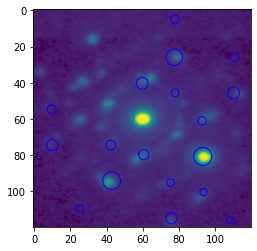

In [12]:
img = grain_list[2].central_diff_pattern
index = index_dataset_with_template_rotation(img, diff_lib_pt,n_best=1)[0]['orientation']

fig, ax = plt.subplots()
plt.imshow(adjust_gamma(img,0.4))
pattern = get_pattern_from_lib_by_angles(diff_lib_pt, *index[0])
# plt.imshow(pattern,alpha = rescale_intensity(pattern,out_range=(0,1))**0.5, cmap="Reds")
diff_spots = get_diff_spot_from_ori(diff_lib_pt, index[0])
plot_spot(diff_spots, ax)
print(index[0])

In [5]:
# import imutils

def draw_spot(img, spots, color = (255,0,0), thickness = 1):
    for i in spots:
        img = cv2.circle(img, i[:2], i[2], color, thickness)
    return img
        
def plot_ori(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 3, diff_center = 'True', index = True, index_plot = True):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        
    frames = []
    frames_num = []
    diff_spots_list = []
    final_index_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            grain_size.append(None); 
            in_plane_ori.append(None);
            frames.append(None);
            diff_spots_list.append(None)
            final_index_list.append(None)
            continue;
        frames_num.append(i)
        grain_size.append(np.sqrt(grain_list_all[i][grain_num].area)/np.pi);
        orientation = grain_list_all[i][grain_num].index[0]
        orientations.append(orientation)

        if diff_center:
            img = grain_list_all[i][grain_num].central_diff_pattern
        else:
            img = grain_list_all[i][grain_num].diff_pattern
            
        index = index_dataset_with_template_rotation(img, diff_lib_pt,n_best=1)[0]['orientation']
        confid = index_dataset_with_template_rotation(img, diff_lib_pt,n_best=1)[0]['correlation']
        final_index = np.concatenate([index[0],[confid[0]]])
        final_index_list.append(final_index)
        diff_spots = get_diff_spot_from_ori(diff_lib_pt, final_index)
        diff_spots_list.append(diff_spots)
        
        
        img = adjust_gamma(img, 0.4)
        contour = grain_list_all[i][grain_num].init_contour
        cY,cX = contour[0].reshape(-1,2).mean(axis = 0)
        grain_loc = (cX, cY)
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        img = rescale_intensity(img,out_range=(0,1))
        data = np.asarray(img) * 255
        data = data.astype(np.uint8)
        frame = cv2.cvtColor(np.asarray(data), cv2.COLOR_GRAY2BGR)
        shape_x, shape_y = frame.shape[0], frame.shape[1]
        inset_x, inset_y = int(shape_x*0.4), int(shape_y*0.4)
        frame[:inset_x,:inset_y] = cv2.resize(img_x, (inset_x, inset_y))
        frames.append(frame)
    fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
    for i,img in enumerate(frames):
        axs[i//3][i%3].axis('off')
        if img is None: continue;
        axs[i//3][i%3].imshow(img)
        axs[i//3][i%3].set_title(final_index_list[i])
        diff_spots = diff_spots_list[i]
        plot_spot(diff_spots, axs[i//3][i%3])
        
    


In [6]:
#clustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib.colors import to_rgb
from skimage.color import label2rgb

def mean_shift_clustering(candidates_list, bandwidth = 15, printing = False, return_list = "all"):             # returning highest correlation orientations of each cluster
    if bandwidth == 0: 
#         bandwidth_ = estimate_bandwidth(candidates_list[:,:3], quantile=0.2, n_samples=5)
        ms = MeanShift(bandwidth=None, bin_seeding=True)
    else: 
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(candidates_list[:,:3])
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    new_candidates_list = np.zeros([n_clusters_, 4])
    all_candidates_list = []
    if printing: print("number of estimated clusters : %d" % n_clusters_)
    for num, i in enumerate(range(n_clusters_)):
        my_members = labels == i
        new_candidates_list[num] = candidates_list[my_members][0]
        all_candidates_list.append(candidates_list[my_members])
    if return_list == 'all':
        return all_candidates_list
    elif return_list == 'label':
        return labels
    else:
        return new_candidates_list
    
def filtered_index(img, diff_lib_pt, n_best = 10, thres = 0.8, frac_keep = 1.0):
    # pre-step, index data with the choice of N_best
    index = index_dataset_with_template_rotation(img, diff_lib_pt,n_best=n_best, frac_keep= frac_keep)[0]['orientation']
    confid = index_dataset_with_template_rotation(img, diff_lib_pt,n_best=n_best, frac_keep= frac_keep)[0]['correlation']
    # first, filter index by confid, threshold is 80% of the largest one
    threshold = confid.max() * thres
    index_filtered = index[confid > threshold]
    confid_filtered = confid[confid > threshold]
    # second, clustering them
    index_filtered = np.concatenate([index_filtered, confid_filtered.reshape(-1,1)],axis = 1)
    return index_filtered


In [7]:
from matplotlib.ticker import MaxNLocator
plt.rcParams["axes.grid"] = True
def find_consist_candidate(ori_list, ori_target):
    ## find the closest clustered orientation with the target
    ## first cluster ori_list, then find the nearest one
    ori_list_clustered = mean_shift_clustering(ori_list, return_list = 'one')
    dist = np.zeros(len(ori_list_clustered))
    for i, ori in enumerate(ori_list_clustered):
        dist[i] = euclidean(ori[:3], ori_target[:3])
    return ori_list_clustered[dist.argmin()], dist.min()

def plot_ipf(ori_list, cols, errs):
    print(errs)
    direction = Vector3d((0, 0, 1))
    orientations = np.radians(ori_list[:,:3])
    ori = Orientation.from_euler(orientations, symmetry.Oh)
    misori_std = [10 for i in orientations]
    ipf = ori.scatter("ipf", direction=direction, return_figure=True, s = errs**2*100, c = cols, alpha=0.5)
    return ipf

def grid_to_xy(grid, pole=-1):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=pole)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    rot_reg_test = rot_reg_test.in_fundamental_sector(symmetry.Oh)
    return np.transpose([s.vector2xy(rot_reg_test)[0],s.vector2xy(rot_reg_test)[1]])

def plot_ori_consist(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 3, diff_center = 'True', index = True, index_plot = True):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    image_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        if diff_center:
            image_list.append(grain_list_all[i][grain_num].central_diff_pattern)
        else:
            image_list.append(grain_list_all[i][grain_num].diff_pattern)
    image_mean = np.array(image_list).mean(axis = 0)
    index_mean = filtered_index(image_mean, diff_lib_pt, frac_keep = 0.3)[0]
    
    frames = []
    frames_num = []
    diff_spots_list = []
    final_index_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            grain_size.append(None); 
            in_plane_ori.append(None);
            frames.append(None);
            diff_spots_list.append(None)
            final_index_list.append([0,0,0,0])
            continue;
            
        if diff_center:
            img = grain_list_all[i][grain_num].central_diff_pattern
        else:
            img = grain_list_all[i][grain_num].diff_pattern
            
        index = filtered_index(img, diff_lib_pt, frac_keep = 0.3)
        final_index, dist = find_consist_candidate(index, index_mean)
#         if dist > 50:                                                 ########### threshold msiorientation = 50 degree
#             grain_size.append(None); 
#             in_plane_ori.append(None);
#             frames.append(None);
#             diff_spots_list.append(None)
#             final_index_list.append([0,0,0,0])
#             continue;
            
        frames_num.append(i)
        grain_size.append(2*np.sqrt(grain_list_all[i][grain_num].area)/np.pi);

        final_index_list.append(final_index)
        diff_spots = get_diff_spot_from_ori(diff_lib_pt, final_index)
        diff_spots_list.append(diff_spots)
        
        
        img = adjust_gamma(img, 0.4)
        contour = grain_list_all[i][grain_num].init_contour
        cY,cX = contour[0].reshape(-1,2).mean(axis = 0)
        grain_loc = (cX, cY)
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        img = rescale_intensity(img,out_range=(0,1))
        data = np.asarray(img) * 255
        data = data.astype(np.uint8)
        frame = cv2.cvtColor(np.asarray(data), cv2.COLOR_GRAY2BGR)
        shape_x, shape_y = frame.shape[0], frame.shape[1]
        inset_x, inset_y = int(shape_x*0.4), int(shape_y*0.4)
        frame[:inset_x,:inset_y] = cv2.resize(img_x, (inset_x, inset_y))
        frames.append(frame)
    fig, axs = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
#     plt.rcParams['axes.titley'] = 0.0    # y is in axes-relative coordinates.
#     plt.rcParams['axes.titlepad'] = 10  # pad is in points...

    final_index_list = np.array(final_index_list)
    for i,img in enumerate(frames[:-1]):
        axs[i//3][i%3].axis('off')
        if img is None: continue;
        axs[i//3][i%3].imshow(img)
        a, b, c = final_index_list[i,:3].round(decimals = 1)
        axs[i//3][i%3].set_title(f'Frame {i}',fontsize = 12)
        axs[i//3][i%3].text(60,115,f'({a}, {b}, {c})',horizontalalignment='center',
             verticalalignment='center', c='white', fontsize = 12)
        diff_spots = diff_spots_list[i]
        plot_spot(diff_spots, axs[i//3][i%3])
        
    axs[2][0].plot(grain_size,'-o')
    axs[2][0].set_title("Grain size",fontsize = 12)
    axs[2][0].tick_params(axis='both', which='major', labelsize=8)
    axs[2][0].text(0,0,'(nm)',fontsize = 8)
    in_plane = final_index_list[:,0]
    in_plane[final_index_list[:,3] == 0] = None
    axs[2][1].plot(in_plane,'-o')
    axs[2][1].set_title("In-plane orientation",fontsize = 12)
    axs[2][1].tick_params(axis='both', which='major', labelsize=8)
    out_of_plane = final_index_list[:,:3]
    out_of_plane = out_of_plane[final_index_list[:,3] != 0]
#     axs[2][2].scatter(*grid_to_xy(out_of_plane), s = 1)
    cols=[(i/len(out_of_plane),0,1-i/len(out_of_plane)) for i in range(len(out_of_plane))]
    ipf = plot_ipf(out_of_plane)
    plt.savefig('image/temp.jpg')
    img = plt.imread('image/temp.jpg')
    img[0:100,280:340] = 255
    axs[2][2].set_title("Out-of-plane orientation",fontsize = 12)
    axs[2][2].imshow(img[18:-18,25:-25])
    axs[2][2].axis('off')
    axs[2][2].spines['top'].set_visible(False)
    axs[2][2].spines['right'].set_visible(False)
    axs[2][2].spines['bottom'].set_visible(False)
    axs[2][2].spines['left'].set_visible(False)
#     axs[2][2].plot(out_of_plane,'-o')
    
    fig.suptitle('Grain chain number ' + str(grain_chain_num), fontsize=16)
    plt.tight_layout()
    
    
def plot_ori_from_index(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 3):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    image_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        image_list.append(grain_list_all[i][grain_num].central_diff_pattern)
    image_mean = np.array(image_list).mean(axis = 0)
    index_mean = filtered_index(image_mean, diff_lib_pt, frac_keep = 0.3)[0]
    print(index_mean)
    frames = []
    frames_num = []
    diff_spots_list = []
    final_index_list = []
    final_index_std_list = []
    grain_size_err = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            in_plane_ori.append(None);
            frames.append(None);
            diff_spots_list.append(None)
            final_index_list.append([0,0,0,0])
            final_index_std_list.append([0,0,0,0])
            continue;
            
        img = grain_list_all[i][grain_num].central_diff_pattern

        final_index = grain_list_all[i][grain_num].index[4]
        
        std_lst = []
        for idx in grain_list_all[i][grain_num].index:
            if euclidean(idx, final_index) < 30: 
                std_lst.append(idx)
        final_index_std = np.array(std_lst).std(axis = 0)
        print(final_index, final_index_std)
        dist = euclidean(final_index[:3], index_mean[:3])
        if dist > 50:                                                 ########### threshold msiorientation = 50 degree
            in_plane_ori.append(None);
            frames.append(None);
            diff_spots_list.append(None)
            final_index_list.append([0,0,0,0])
            final_index_std_list.append([0,0,0,0])
            continue;
            
        frames_num.append(i)
        grain_size.append(2*np.sqrt(grain_list_all[i][grain_num].area)/np.pi);
        grain_size_err.append(1)
        final_index_list.append(final_index)
        final_index_std_list.append(final_index_std)
        diff_spots = get_diff_spot_from_ori(diff_lib_pt, final_index)
        diff_spots_list.append(diff_spots)
        
        
        img = adjust_gamma(img, 0.4)
        contour = grain_list_all[i][grain_num].init_contour
        cY,cX = contour[0].reshape(-1,2).mean(axis = 0)
        grain_loc = (cX, cY)
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        img = rescale_intensity(img,out_range=(0,1))
        data = np.asarray(img) * 255
        data = data.astype(np.uint8)
        frame = cv2.cvtColor(np.asarray(data), cv2.COLOR_GRAY2BGR)
        shape_x, shape_y = frame.shape[0], frame.shape[1]
        inset_x, inset_y = int(shape_x*0.4), int(shape_y*0.4)
        frame[:inset_x,:inset_y] = cv2.resize(img_x, (inset_x, inset_y))
        frames.append(frame)
    fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
#     plt.rcParams['axes.titley'] = 0.0    # y is in axes-relative coordinates.
#     plt.rcParams['axes.titlepad'] = 10  # pad is in points...

    final_index_list = np.array(final_index_list)
    final_index_std_list = np.array(final_index_std_list)
    for i,img in enumerate(frames[:-1]):
        axs[i//3][i%3].axis('off')
        if img is None: continue;
        axs[i//3][i%3].imshow(img)
        a, b, c = final_index_list[i,:3].round(decimals = 1)
        axs[i//3][i%3].set_title(f'Frame {i}',fontsize = 12)
        axs[i//3][i%3].text(60,115,f'({a}, {b}, {c})',horizontalalignment='center',
             verticalalignment='center', c='white', fontsize = 12)
        diff_spots = diff_spots_list[i]
        plot_spot(diff_spots, axs[i//3][i%3])
        
    cols=[(i/len(frames_num),0,1-i/len(frames_num)) for i in range(len(frames_num))]
    axs[2][0].errorbar(frames_num,grain_size, yerr=grain_size_err,c='grey')
    axs[2][0].scatter(frames_num,grain_size,color = cols, s= 70)
    axs[2][0].set_title("Grain size",fontsize = 12)
    axs[2][0].tick_params(axis='both', which='major', labelsize=8)
    axs[2][0].text(-0.1,1.03,'nm',fontsize = 10, c='k', transform=axs[2][0].transAxes)
    axs[2][0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2][0].set_xlabel('Frame',fontsize = 10)
    axs[2][0].grid(False)
    in_plane = final_index_list[:,0]
    in_plane_error = final_index_std_list[:,0]
    in_plane = in_plane[final_index_list[:,3] != 0]
    in_plane_error= in_plane_error[final_index_list[:,3] != 0]
    axs[2][1].errorbar(frames_num,in_plane, yerr=in_plane_error,c='grey')
    axs[2][1].scatter(frames_num,in_plane,color = cols, s= 70)
    axs[2][1].set_title("In-plane orientation",fontsize = 12)
    axs[2][1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2][1].set_xlabel('Frame',fontsize = 10)
    axs[2][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2][1].tick_params(axis='both', which='major', labelsize=8)
    axs[2][1].text(-0.15,1.03,'deg.',fontsize = 10, c='k', transform=axs[2][1].transAxes)
    axs[2][1].grid(False)
    out_of_plane = final_index_list[:,:3]
    out_of_plane = out_of_plane[final_index_list[:,3] != 0]
    out_of_plane_err = final_index_std_list[:,1:3][final_index_list[:,3] != 0].mean(axis = 0)
    for i in range(len(out_of_plane_err)):
        out_of_plane_err[i] = max(out_of_plane_err[i], 1)
#     axs[2][2].scatter(*grid_to_xy(out_of_plane), s = 1)
    out_of_plane_err = np.array(out_of_plane_err)
    spots = grid_to_xy(out_of_plane)
    ipf = plot_ipf(out_of_plane,cols, errs = out_of_plane_err)
    lines = [(tuple(v_1), tuple(v_2)) for v_1,v_2 in zip(spots[:-1],spots[1:])]
    ax = ipf.axes[0]
    ax.add_collection(LineCollection(lines, colors='k'))

    plt.savefig('image/temp.jpg')
    img = plt.imread('image/temp.jpg')
    img[0:100,280:340] = 255
    img = img[0:490,80:570]
    axs[2][2].set_title("Out-of-plane orientation",fontsize = 12)
    axs[2][2].imshow(img)
    axs[2][2].axis('off')
    axs[2][2].spines['top'].set_visible(False)
    axs[2][2].spines['right'].set_visible(False)
    axs[2][2].spines['bottom'].set_visible(False)
    axs[2][2].spines['left'].set_visible(False)
#     axs[2][2].plot(out_of_plane,'-o')
    
    fig.suptitle('Grain chain number ' + str(grain_chain_num), fontsize=16)
    plt.tight_layout()
    fig1.savefig('image/temp_.jpg')
    img = cv2.resize(img,[240,240], interpolation = cv2.INTER_AREA)
    img_all = plt.imread('image/temp_.jpg')
    img_all[600:840,580:820] = img
    cv2.imwrite(f"image/grain_chain_{grain_chain_num}.jpg",img_all)
    
    
def plot_ori_from_index_compact(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 3):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    image_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        image_list.append(grain_list_all[i][grain_num].central_diff_pattern)
    image_mean = np.array(image_list).mean(axis = 0)
    index_mean = filtered_index(image_mean, diff_lib_pt, frac_keep = 0.3)[0]
    print(index_mean)
    frames = []
    frames_num = []
    diff_spots_list = []
    final_index_list = []
    final_index_std_list = []
    grain_size_err = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
            
        img = grain_list_all[i][grain_num].central_diff_pattern

        final_index = grain_list_all[i][grain_num].index[4]
        
        std_lst = []
        for idx in grain_list_all[i][grain_num].index:
            if euclidean(idx, final_index) < 30: 
                std_lst.append(idx)
        final_index_std = np.array(std_lst).std(axis = 0)
        print(final_index, final_index_std)
        dist = euclidean(final_index[:3], index_mean[:3])
        if dist > 50:                                                 ########### threshold msiorientation = 50 degree
            in_plane_ori.append(None);
            frames.append(None);
            diff_spots_list.append(None)
            final_index_list.append([0,0,0,0])
            final_index_std_list.append([0,0,0,0])
            continue;
            
        frames_num.append(i)
        grain_size.append(2*np.sqrt(grain_list_all[i][grain_num].area)/np.pi);
        grain_size_err.append(1)
        final_index_list.append(final_index)
        final_index_std_list.append(final_index_std)
        diff_spots = get_diff_spot_from_ori(diff_lib_pt, final_index)
        diff_spots_list.append(diff_spots)
        
        
        img = adjust_gamma(img, 0.4)
        contour = grain_list_all[i][grain_num].init_contour
        cY,cX = contour[0].reshape(-1,2).mean(axis = 0)
        grain_loc = (cX, cY)
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        img = rescale_intensity(img,out_range=(0,1))
        data = np.asarray(img) * 255
        data = data.astype(np.uint8)
        frame = cv2.cvtColor(np.asarray(data), cv2.COLOR_GRAY2BGR)
        shape_x, shape_y = frame.shape[0], frame.shape[1]
        inset_x, inset_y = int(shape_x*0.4), int(shape_y*0.4)
        frame[:inset_x,:inset_y] = cv2.resize(img_x, (inset_x, inset_y))
        frames.append(frame)
    
#     plt.rcParams['axes.titley'] = 0.0    # y is in axes-relative coordinates.
#     plt.rcParams['axes.titlepad'] = 10  # pad is in points...

    final_index_list = np.array(final_index_list)
    final_index_std_list = np.array(final_index_std_list)
    if len(frames) <= 3: rows = 2
    else: rows = 3
    fig1, axs = plt.subplots(nrows=rows,ncols=3, figsize=(9,3*rows))
    if len(frames) == 7: frames = frames[:-1]
    for i in range(3*rows-3):
        axs[i//3][i%3].axis('off')
    for i,img in enumerate(frames):
        if img is None: continue;
        axs[i//3][i%3].imshow(img)
        a, b, c = final_index_list[i,:3].round(decimals = 1)
        axs[i//3][i%3].set_title(f'Frame {i}',fontsize = 12)
        axs[i//3][i%3].text(60,115,f'({a}, {b}, {c})',horizontalalignment='center',
             verticalalignment='center', c='white', fontsize = 12)
        diff_spots = diff_spots_list[i]
        plot_spot(diff_spots, axs[i//3][i%3])
        
    cols=[(i/len(frames_num),0,1-i/len(frames_num)) for i in range(len(frames_num))]
    frame_x = np.arange(len(grain_size))
    axs[rows-1][0].errorbar(frame_x,grain_size, yerr=grain_size_err,c='grey')
    axs[rows-1][0].scatter(frame_x,grain_size,color = cols, s= 70)
    axs[rows-1][0].set_title("Grain size",fontsize = 12)
    axs[rows-1][0].tick_params(axis='both', which='major', labelsize=8)
    axs[rows-1][0].text(-0.1,1.03,'nm',fontsize = 10, c='k', transform=axs[rows-1][0].transAxes)
    axs[rows-1][0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][0].set_xlabel('Frame',fontsize = 10)
    axs[rows-1][0].grid(False)
    in_plane = final_index_list[:,0]
    in_plane_error = final_index_std_list[:,0]
    in_plane = in_plane[final_index_list[:,3] != 0]
    in_plane_error= in_plane_error[final_index_list[:,3] != 0]
    axs[rows-1][1].errorbar(frame_x,in_plane, yerr=in_plane_error,c='grey')
    axs[rows-1][1].scatter(frame_x,in_plane,color = cols, s= 70)
    axs[rows-1][1].set_title("In-plane orientation",fontsize = 12)
    axs[rows-1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][1].set_xlabel('Frame',fontsize = 10)
    axs[rows-1][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][1].tick_params(axis='both', which='major', labelsize=8)
    axs[rows-1][1].text(-0.15,1.03,'deg.',fontsize = 10, c='k', transform=axs[rows-1][1].transAxes)
    axs[rows-1][1].grid(False)
    out_of_plane = final_index_list[:,:3]
    out_of_plane = out_of_plane[final_index_list[:,3] != 0]
    out_of_plane_err = final_index_std_list[:,1:3][final_index_list[:,3] != 0].mean(axis = 0)
    for i in range(len(out_of_plane_err)):
        out_of_plane_err[i] = max(out_of_plane_err[i], 1)
#     axs[2][2].scatter(*grid_to_xy(out_of_plane), s = 1)
    spots = grid_to_xy(out_of_plane)
    print(out_of_plane,out_of_plane_err)
    ipf = plot_ipf(out_of_plane,cols, errs = out_of_plane_err)
    lines = [(tuple(v_1), tuple(v_2)) for v_1,v_2 in zip(spots[:-1],spots[1:])]
    ax = ipf.axes[0]
    ax.add_collection(LineCollection(lines, colors='k'))

    
def plot_morph(grain_chain, grain_list_all, diff_lib_pt, grain_chain_num, scale = 5):

    grain_size = []
    in_plane_ori = []
    orientations = []
    
    grain_loc = []
    grain_size_max = 0
    image_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: continue;
        grain_size_ = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        grain_size_max = max(grain_size_max, grain_size_)
        image_list.append(grain_list_all[i][grain_num].central_diff_pattern)
    image_mean = np.array(image_list).mean(axis = 0)
    index_mean = filtered_index(image_mean, diff_lib_pt, frac_keep = 0.3)[0]
    print(index_mean)
    frames = []
    frames_num = []
    diff_spots_list = []
    final_index_list = []
    final_index_std_list = []
    grain_size_err = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
            
        img = grain_list_all[i][grain_num].central_diff_pattern

        final_index = grain_list_all[i][grain_num].index[4]
        
        std_lst = []
        for idx in grain_list_all[i][grain_num].index:
            if euclidean(idx, final_index) < 30: 
                std_lst.append(idx)
        final_index_std = np.array(std_lst).std(axis = 0)
        print(final_index, final_index_std)
        dist = euclidean(final_index[:3], index_mean[:3])
#         if dist > 50:                                                 ########### threshold msiorientation = 50 degree
#             in_plane_ori.append(None);
#             frames.append(None);
#             diff_spots_list.append(None)
#             final_index_list.append([0,0,0,0])
#             final_index_std_list.append([0,0,0,0])
#             continue;
            
        frames_num.append(i)
        grain_size.append(2*np.sqrt(grain_list_all[i][grain_num].area)/np.pi);
        grain_size_err.append(1)
        final_index_list.append(final_index)
        final_index_std_list.append(final_index_std)

        contour = grain_list_all[i][grain_num].init_contour
        if not contour: continue;
        cY,cX = contour[0].reshape(-1,2).mean(axis = 0)
        grain_loc = (cX, cY)
        left = int(grain_loc[1]-scale*grain_size_max)
        right = int(grain_loc[1]+scale*grain_size_max)
        bottom = int(grain_loc[0]-scale*grain_size_max)
        top = int(grain_loc[0]+scale*grain_size_max)
        left, bottom = max(0, left), max(0, bottom)
        top, right = min(400, top), min(400, right)
        num_mapping = i+3
        img_x = cv2.imread(f"image/index_mapping_unshifted_{num_mapping}_x.jpeg")
        cv2.drawContours(img_x, contour, -1, 255, thickness = 1, lineType =cv2.LINE_AA)
        img_x = img_x[bottom:top,left:right]
        frames.append(img_x)
    
#     plt.rcParams['axes.titley'] = 0.0    # y is in axes-relative coordinates.
#     plt.rcParams['axes.titlepad'] = 10  # pad is in points...

    final_index_list = np.array(final_index_list)
    final_index_std_list = np.array(final_index_std_list)
    if len(frames) <= 3: rows = 2
    else: rows = 3
    fig1, axs = plt.subplots(nrows=rows,ncols=3, figsize=(9,3*rows))
    if len(frames) == 7: frames = frames[:-1]
    for i in range(3*rows-3):
        axs[i//3][i%3].axis('off')
    for i,img in enumerate(frames):
        if img is None: continue;
        axs[i//3][i%3].imshow(img)
        a, b, c = final_index_list[i,:3].round(decimals = 1)
        axs[i//3][i%3].set_title(f'Frame {i}',fontsize = 12)
        
    cols=[(i/len(frames_num),0,1-i/len(frames_num)) for i in range(len(frames_num))]
    axs[rows-1][0].errorbar(frames_num,grain_size, yerr=grain_size_err,c='grey')
    axs[rows-1][0].scatter(frames_num,grain_size,color = cols, s= 70)
    axs[rows-1][0].set_title("Grain size",fontsize = 12)
    axs[rows-1][0].tick_params(axis='both', which='major', labelsize=8)
    axs[rows-1][0].text(-0.1,1.03,'nm',fontsize = 10, c='k', transform=axs[rows-1][0].transAxes)
    axs[rows-1][0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][0].set_xlabel('Frame',fontsize = 10)
    axs[rows-1][0].grid(False)
    in_plane = final_index_list[:,0]
    in_plane_error = final_index_std_list[:,0]
    in_plane = in_plane[final_index_list[:,3] != 0]
    in_plane_error= in_plane_error[final_index_list[:,3] != 0]
    axs[rows-1][1].errorbar(frames_num,in_plane, yerr=in_plane_error,c='grey')
    axs[rows-1][1].scatter(frames_num,in_plane,color = cols, s= 70)
    axs[rows-1][1].set_title("In-plane orientation",fontsize = 12)
    axs[rows-1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][1].set_xlabel('Frame',fontsize = 10)
    axs[rows-1][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[rows-1][1].tick_params(axis='both', which='major', labelsize=8)
    axs[rows-1][1].text(-0.15,1.03,'deg.',fontsize = 10, c='k', transform=axs[rows-1][1].transAxes)
    axs[rows-1][1].grid(False)
    out_of_plane = final_index_list[:,:3]
    out_of_plane = out_of_plane[final_index_list[:,3] != 0]
    out_of_plane_err = final_index_std_list[:,1:3][final_index_list[:,3] != 0].mean(axis = 0)
    for i in range(len(out_of_plane_err)):
        out_of_plane_err[i] = max(out_of_plane_err[i], 1)
#     axs[2][2].scatter(*grid_to_xy(out_of_plane), s = 1)
    spots = grid_to_xy(out_of_plane)
    print(out_of_plane,out_of_plane_err)
    ipf = plot_ipf(out_of_plane,cols, errs = out_of_plane_err)
    lines = [(tuple(v_1), tuple(v_2)) for v_1,v_2 in zip(spots[:-1],spots[1:])]
    ax = ipf.axes[0]
    ax.add_collection(LineCollection(lines, colors='k'))

    plt.savefig('image/temp.jpg')
    img = plt.imread('image/temp.jpg')
    img[0:100,280:340] = 255
    img = img[8:480,88:560]
    axs[rows-1][2].set_title("Out-of-plane orientation",fontsize = 12)
    axs[rows-1][2].imshow(img)
    axs[rows-1][2].axis('off')
    axs[rows-1][2].spines['top'].set_visible(False)
    axs[rows-1][2].spines['right'].set_visible(False)
    axs[rows-1][2].spines['bottom'].set_visible(False)
    axs[rows-1][2].spines['left'].set_visible(False)
#     axs[2][2].plot(out_of_plane,'-o')
    

In [8]:
# FIND all grain chain with large rotation
import shutil

def misori_from_euler(euler1, euler2):
    data = np.array([euler1, euler2])
    data = np.radians(data)
    m = Misorientation.from_euler(data)
    return np.rad2deg((m.distance()))[0,1]

def determine_misori(grain_chain, grain_list_all, grain_chain_num):
    misori_list = []
    ori_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        final_index = grain_list_all[i][grain_num].index[4]
        ori_list.append(final_index[:3])
    for ori_1, ori_2 in zip(ori_list[:-1],ori_list[1:]):
        misori = misori_from_euler(ori_2,ori_1)
        misori_list.append(misori)
    return np.array(misori_list)

def determine_size_change(grain_chain, grain_list_all, grain_chain_num):
    size_list = []
    delta_size_list = []
    for i,grain_num in enumerate(grain_chain[::-1]):
        if grain_num == -1: 
            continue;
        grain_size = np.sqrt(grain_list_all[i][grain_num].area)/np.pi
        size_list.append(grain_size)
    for size_1, size_2 in zip(size_list[:-1],size_list[1:]):
        delta_size = size_2 - size_1
        delta_size_list.append(delta_size)
    return np.array(delta_size_list)
        
def threshold_misori_in_chains(grain_chains, grain_list_all, thres):  # return all chain numbers if one rotation beyond threshold
    grain_chain_num_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        for misori in misoris:
            if misori > thres:
                grain_chain_num_list.append(num);
                break;
    return np.array(grain_chain_num_list)

def find_misori_w_size_for_all_pairs(grain_chains, grain_list_all, misori_thres = 50): # find all frame pairs that rotation beyond threshold
    grain_chain_list = []
    for num, grain_chain in enumerate(grain_chains):
        misoris = determine_misori(grain_chain, grain_list_all, num)
        delta_grain_sizes = determine_size_change(grain_chain, grain_list_all, num)
        for misori, delta_grain_size in zip(misoris, delta_grain_sizes):
            if misori < misori_thres:
                grain_chain_list.append([num,misori, delta_grain_size])
    return np.array(grain_chain_list)

from scipy.ndimage import binary_erosion, binary_dilation
def update_load(grain, dilation = True):
    if dilation:
        grain.load_map = binary_dilation(grain.load_map,iterations=1)
    else:
        grain.load_map = binary_erosion(grain.load_map,iterations=1)
    grain.area = grain.load_map.sum()
        
from collections import deque

def update_load_by_dfs(grain, index_map, gb_misori_threshold):
    grain.load_map = np.zeros(grain.load_map.shape, dtype=bool)
    cols, rows = index_map.shape[:2]
    center = [int(grain.loc[0]),int(grain.loc[1])]
    
    boundary = deque([center])
    grain.load_map[center[0],center[1]] = True
    
    while boundary:
        node = boundary.popleft()
        node_index = index_map[node[0],node[1]][0,:3]
        node_list = [[node[0]-1, node[1]],[node[0]+1, node[1]],[node[0], node[1]-1],[node[0], node[1]+1]]
        for current_node in node_list:
            if 0<=current_node[0]<cols and 0<=current_node[1]<rows:
                current_node_index = index_map[current_node[0],current_node[1]][0,:3]
                if euclidean(node_index,current_node_index) < gb_misori_threshold \
                and grain.load_map[current_node[0],current_node[1]] == False:
                        boundary.append(current_node); grain.load_map[current_node[0],current_node[1]] = True
    
def update_contour(grain):
    contours, hierarchy = cv2.findContours(np.uint8(grain.load_map), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    grain.init_contour = contours
    


129


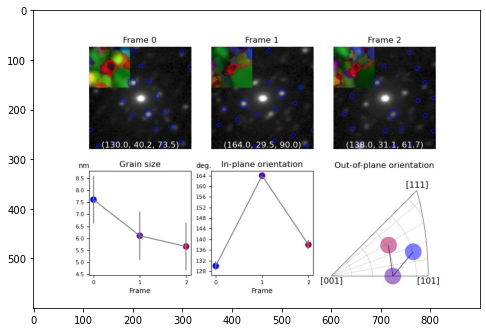

In [20]:
ori_thres = grain_chain_info[:,1] > 5 
size_thres = abs(grain_chain_info[:,2]) < 0.5
all_thres = np.bitwise_and(ori_thres, size_thres)
fulfilled_grain_chain = grain_chain_info[all_thres][:,0].astype(int)

num = rd.randint(0, len(fulfilled_grain_chain)-1)
grain_chain_num = fulfilled_grain_chain[num]
img = cv2.imread(f"image/grain_chain_{grain_chain_num}.jpg")
plt.figure(figsize=(8,8))
print(num)
plt.imshow(img)
plt.grid(False)